# Decision Tree Regression on Diabetes Dataset
This notebook demonstrates how to use scikit-learn's DecisionTreeRegressor for predicting disease progression. We cover:
- Dataset loading and exploration
- Key formulas (MSE, variance reduction)
- Exploratory feature-target visualization
- Training DecisionTreeRegressor (default and tuned)
- Visualizing the regression tree and prediction surface
- Model evaluation with MSE, MAE, and R²
- Hyperparameter tuning (max_depth)
- Final discussion of results

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sns.set_theme()


## Data Loading & Exploration
Load the diabetes dataset and inspect its shape and basic statistics.

In [12]:
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='progression')
print(f"Feature matrix shape: {X.shape}")
X.head()

Feature matrix shape: (442, 10)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [13]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: progression, dtype: float64

## Exploratory Visualization
Plot **BMI** vs disease progression to inspect their relationship.

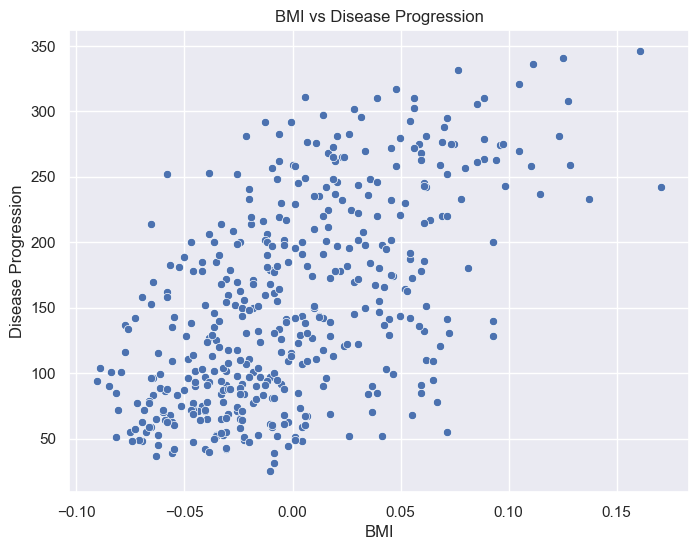

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X['bmi'], y=y)
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('BMI vs Disease Progression')
plt.show()

## Train/Test Split
Split the data into 80% train and 20% test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 353, Test samples: 89


## Training Default Decision Tree Regressor
Fit DecisionTreeRegressor with default settings (criterion='squared_error').

In [16]:
reg = DecisionTreeRegressor(random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"R²:  {r2_score(y_test, y_pred):.3f}")

MSE: 4976.798
MAE: 54.528
R²:  0.061


## Visualizing the Regression Tree
Plot the trained tree limited to depth=3.

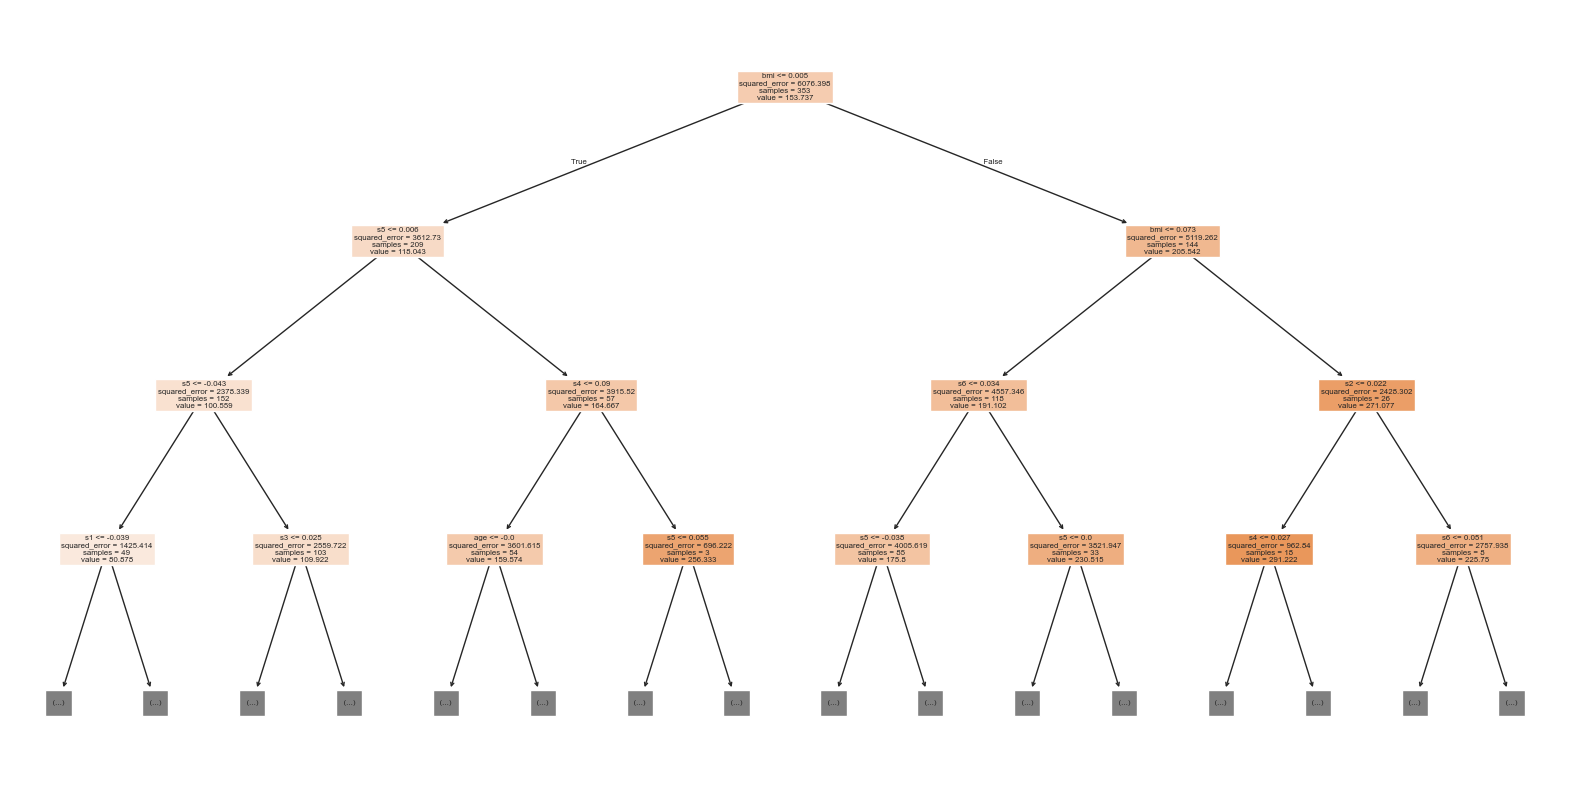

In [17]:
plt.figure(figsize=(20,10))
plot_tree(reg, max_depth=3, feature_names=data.feature_names, filled=True)
plt.show()

## Prediction Surface (2 Features)
Use **bmi** and **age** to visualize the regressor's prediction surface.

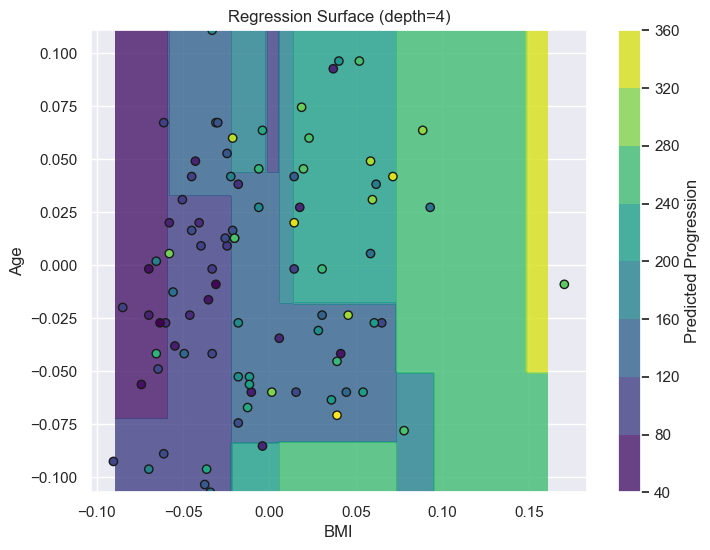

In [18]:
X2_train = X_train[['bmi','age']].values
X2_test = X_test[['bmi','age']].values
reg2 = DecisionTreeRegressor(max_depth=4, random_state=42)
reg2.fit(X2_train, y_train)
xx, yy = np.meshgrid(
    np.linspace(X2_train[:,0].min(), X2_train[:,0].max(), 200),
    np.linspace(X2_train[:,1].min(), X2_train[:,1].max(), 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = reg2.predict(grid).reshape(xx.shape)
plt.figure(figsize=(8,6))
cf = plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.8)
plt.colorbar(cf, label='Predicted Progression')
plt.scatter(X2_test[:,0], X2_test[:,1], c=y_test, cmap='viridis', edgecolor='k')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.title('Regression Surface (depth=4)')
plt.show()

## Effect of `max_depth` on Classification Performance

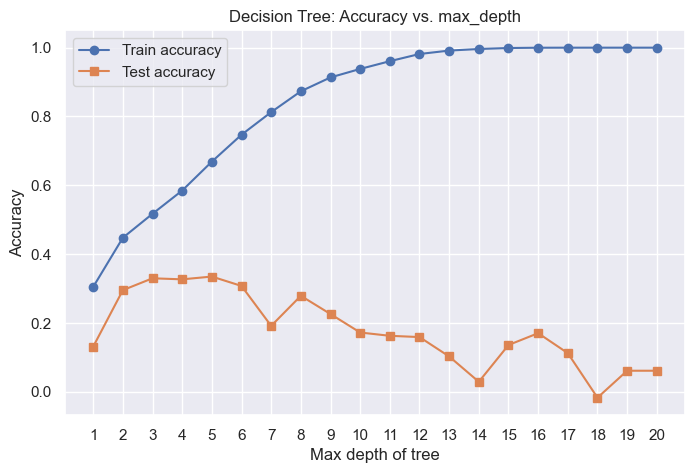

In [20]:
# Range of depths to try
depths = list(range(1, 21))

train_acc = []
test_acc  = []

for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    train_acc.append(dt.score(X_train, y_train))
    test_acc.append(dt.score(X_test, y_test))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(depths, train_acc, marker='o', label='Train accuracy')
plt.plot(depths, test_acc,  marker='s', label='Test accuracy')
plt.xlabel('Max depth of tree')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Accuracy vs. max_depth')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

## Effect of Tree Depth on Accuracy

- **Underfitting at Low Depths (1–2)**  
  At very shallow depths, the model is too simple to capture the underlying patterns. Both train and test accuracy are low (around 30–45%), indicating that the tree is under-fitting the data.

- **Sweet Spot (Depth 3–5)**  
  As we increase max_depth to 3–5, test accuracy rises and peaks around depth 4–5 (≈33 – 34%). This is where the tree has just enough capacity to model the key relationships without memorizing noise, striking a good bias–variance balance.

- **Overfitting for Large Depths (>5)**  
  - **Training accuracy** continues climbing and quickly reaches 100% by depth 10–12, showing the model can perfectly memorize the training set.  
  - **Test accuracy** then steadily declines (even dipping to near zero at depth 14 and again at 18), revealing severe overfitting.

- **High Variance at Very Large Depths**  
  The fluctuations in test accuracy for depths 15–20 (e.g. a small rebound at 16, a collapse at 18) reflect high variance: tiny changes in the training labels or split points cause drastically different decision boundaries.

- **Choosing the Optimal Depth**  
  Based on these curves, a **max_depth of about 4 or 5** would be best—where test accuracy is maximized and the gap to train accuracy remains modest. Constraining tree depth is an effective way to control overfitting in decision trees.
